In [ ]:
!pip -q install ./python

In [1]:
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from config import Config
from model import Actor, Critic
from memory import ReplayBuffer
from noise import OUNoise
from ddpg_agent import Agent
from multi_agent import MultiAgent

import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
env_info = env.reset(train_mode=True)[brain_name]

In [3]:
config = Config()

config.seed = 2
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.action_size = brain.vector_action_space_size
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)

config.actor_hidden_units = (512,256)
config.actor_network_fn = lambda: Actor(config.action_size, config.state_size, config.actor_hidden_units, config.seed).to(config.device)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_hidden_units = (512,256)
config.weight_decay = 0
config.critic_network_fn = lambda: Critic(config.action_size, config.state_size, config.critic_hidden_units, config.seed).to(config.device)
config.critic_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)

config.update_every = 4
config.memory_fn = lambda: ReplayBuffer(config.action_size, config.buffer_size, config.batch_size, config.seed, config.device)

config.noise_fn = lambda: OUNoise(config.action_size, config.seed)

In [8]:
MA = MultiAgent(config)

def maddpg(n_episodes=30000, max_t=2000):
    all_scores = []
    scores_window = deque(maxlen=100)
    max_scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        MA.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for i in range(max_t):
            actions = MA.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            MA.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
                
        avg_score = np.mean(scores)
        max_score = np.max(scores)
        scores.append(avg_score)
        max_scores.append(max_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.5f} \tMax Average Score: {:.5f}'.format(i_episode, np.mean(scores), np.mean(max_scores_window)), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
        if np.mean(scores)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-5, np.mean(scores)))
            torch.save(MA.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(MA.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
        if (i_episode > 100) & (np.mean(scores)>=0.5):
            print('\nFinal Average Score: {:.2f}'.format(np.mean(scores_window)))
            torch.save(MA.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(MA.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

C:\Users\kaixi\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 60	Average Score: 0.51517 	Max Average Score: 0.7321706
Environment solved in 55 episodes!	Average Score: 0.52
Episode 61	Average Score: 0.55328 	Max Average Score: 0.76869
Environment solved in 56 episodes!	Average Score: 0.55
Episode 62	Average Score: 0.59169 	Max Average Score: 0.80871
Environment solved in 57 episodes!	Average Score: 0.59
Episode 63	Average Score: 0.63040 	Max Average Score: 0.84921
Environment solved in 58 episodes!	Average Score: 0.63
Episode 64	Average Score: 0.67469 	Max Average Score: 0.90047
Environment solved in 59 episodes!	Average Score: 0.67
Episode 65	Average Score: 0.71938 	Max Average Score: 0.94308
Environment solved in 60 episodes!	Average Score: 0.72
Episode 66	Average Score: 0.76311 	Max Average Score: 0.98758
Environment solved in 61 episodes!	Average Score: 0.76
Episode 67	Average Score: 0.81216 	Max Average Score: 1.03403
Environment solved in 62 episodes!	Average Score: 0.81
Episode 68	Average Score: 0.85074 	Max Average Score: 1.07015


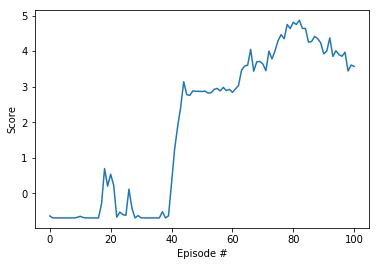

In [9]:
scores = maddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()